### Exploratory analysis and price prediction of real estate in New York City.
types of analysis: Descriptive, Predictive  
performed by: Vasyl Zhepikov  
contact email: Vasyl.Zhepikov@gmail.com
* Please, see attached HTML reports in the filder. 


#### 1. Explloratory analysis of the data
Perform exploratory analysis on this dataset and produce a showcase/storyline of a few interesting patterns and your observations.

#### 2. Price prediction
Build a simple model that can predict SALE_PRICE of a given case given all the other columns available in the dataset.

2.1 Model selection  
* Normalizing and scaling data building pipelines  

2.2 Model evaluation for regression problems using Cross Validation  
* Sum of squared errors (SSE)  
* Mean squared error (MSE)  
* R-squared (R2)  

2.3 Considerations on Regularization  
* Lasso  
* Ridge  

2.4 Choose the best model  

### 1. Explloratory analysis of the data
Perform exploratory analysis on this dataset and produce a showcase/storyline of a few interesting patterns and your observations.

1.1 Load, clean, explore the data  
1.1.1 Check for data types (categorical, numerical, mixed) and types of "assumed" by pandas  
  * Convert if improper data type   

1.1.2 Visual check for misspellings. Misspelling patterns.  

1.1.3 Exploring  missing values
  * Drop columns with more than 40% missing values  
  * Drop NULL rows 
  
1.1.4 Exploring outliers (drop or keep)   

1.1.5 Check and account for duplicates   

1.1.6 Check for logically redundant features  

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import missingno as msno
import itertools
from collections import Counter
import  category_encoders as ce
from dython.nominal import associations
import phik
from phik import resources, report
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RANSACRegressor

# import scores for regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
%matplotlib inline

In [2]:
df = pd.read_csv(r'nyc-rolling-sales.csv')

* Changing Borough names in accordance with zip codes.

In [3]:
conditions = [(df['ZIP CODE'] >= 10001) & (df['ZIP CODE'] <=10282) , 
                (df['ZIP CODE'] >= 10301) & (df['ZIP CODE'] <=10314) ,
                (df['ZIP CODE'] >= 10451) & (df['ZIP CODE'] <=10475) ,
                (df['ZIP CODE'] >= 11201) & (df['ZIP CODE'] <=112256) ,
((df['ZIP CODE'] >= 11004) & (df['ZIP CODE'] <=11109)) | ((df['ZIP CODE'] >= 11351) & (df['ZIP CODE'] <=11697))]
values = ['Manhattan', 'Staten Island', 'Bronx', 'Brooklyn', 'Queens']   

df['BOROUGH'] = np.select(conditions, values, default='Unknown')

In [4]:
# profile = df.profile_report( title='NYC Rolling Sales Report')
# profile.to_file(output_file="NYC Rolling Sales Report")
# df.profile_report( title='NYC Rolling Sales Report')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  object
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

#### 1.1.1 Check for data types (categorical, numerical, mixed) and types of "assumed" by pandas. Convert if improper data type 

After looking on data types I have decided to convert some of them to proper data types and investigate further.
I have identified 5 columns with improper data types: 
  * Correct LAND SQUARE FEET to numeric and GROSS SQUARE FEET to numeric
  * Check TAX CLASS AT PRESENT and TAX CLASS AT TIME OF SALE to determine proper data type.
  * correct SALE PRICE to numeric
  * convert SALE DATE to datetime

* Correct LAND SQUARE FEET to numeric and GROSS SQUARE FEET to numeric.  
I checked the data and found that there are some values that are ment to represent missing values, such as ' -  '.  
I have decided to check other columns for the same pattern and found that there are 3 columns with the same pattern.  
I have decided to drop rows with missing values in dependent variable - SALE PRICE.  
I have decided to change the pattern to NaN, change types and decided on dealing with missing values later.  

In [6]:
for col in df.columns:
    if df[col].dtype == 'object':
        if df[df[col].str.contains(' -  ')].shape[0] > 0:
            print(col,f"{round(df[df[col].str.contains(' -  ')].shape[0]/df.shape[0]*100,2)} % of values are Missing.")


LAND SQUARE FEET 31.05 % of values are Missing.
GROSS SQUARE FEET 32.66 % of values are Missing.
SALE PRICE 17.22 % of values are Missing.


In [7]:
df['SALE PRICE'] = df['SALE PRICE'].replace(' -  ',np.nan)

In [8]:
df['LAND SQUARE FEET'].replace(' -  ',np.nan, inplace=True)
df['GROSS SQUARE FEET'].replace(' -  ',np.nan, inplace=True)

In [9]:
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].astype('float64')
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].astype('float64')

#### Check Tax Class at Present and Tax Class at Time of Sale
From report we see 738 values at Tax Class at Present are missing. = ' '. And values are Categorical strings.  
From report we see Tax Class at Time of Sale does not have any missing values. And Values are Categorical integers.  

After Checking correlation and building a categorical barplot to see whether values are the same or not and how correlated they are. And We have perfect 1.00 correlation. To avoid multicolinearity I have decided to drop Tax Class at Present column. As it has some missing values and values are almost the same as in Tax Class at Time of Sale.

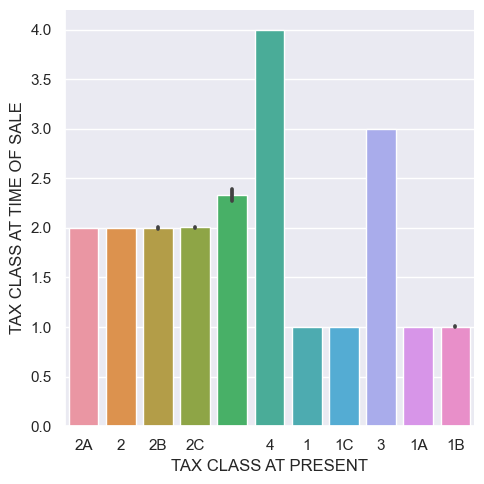

In [10]:
sns.catplot(x='TAX CLASS AT PRESENT', y='TAX CLASS AT TIME OF SALE', data=df, kind='bar')

In [11]:
df[['TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']].corr('spearman')

C:\Users\Vasyl\AppData\Local\Temp\ipykernel_4460\1566384464.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[['TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']].corr('spearman')


,TAX CLASS AT TIME OF SALE
TAX CLASS AT TIME OF SALE,1.00


In [12]:
df = df.drop(columns=['TAX CLASS AT PRESENT']).copy(deep=True)

In [13]:
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')

#### Correct sale price to numeric

In [14]:
df['SALE PRICE'] = df['SALE PRICE'].astype('float64')

#### Convert sale date to datetime

In [15]:
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

#### ZIP CODE to category

In [16]:
df['ZIP CODE'] = df['ZIP CODE'].astype('category')

#### Other Columns

Unnamed: 0  
After looking at the data I have decided to drop this column as it is just an commulative aggregation of BOROUGH column with subsequent numbers, which looks like an index due to high cardinality and sequence. On a top of it all it is somewhat correlated with BOROUGH column and has no correlation with SALE PRICE.

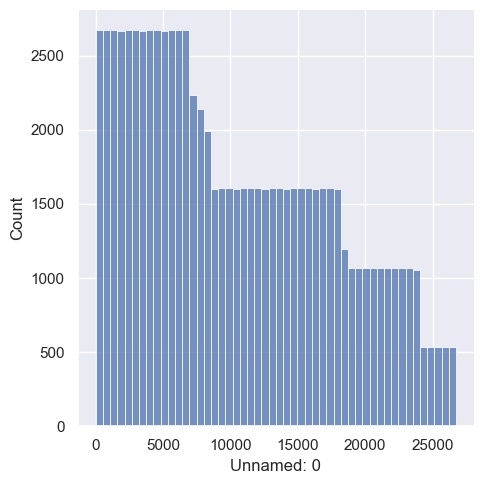

In [17]:
# plot distribution of Unnamed: 0
sns.displot(df['Unnamed: 0'])

<AxesSubplot: xlabel='Unnamed: 0', ylabel='SALE PRICE'>

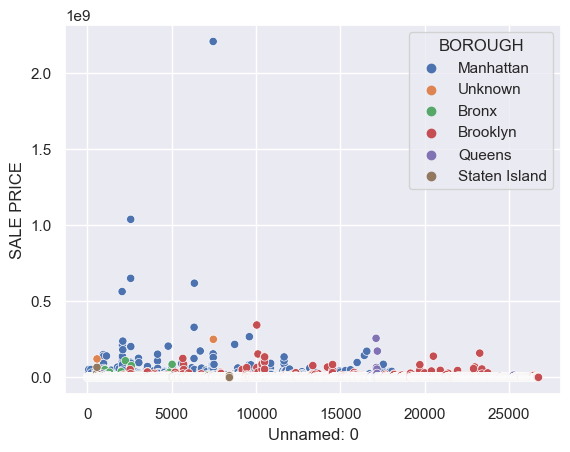

In [18]:
# plot correlation for numerical Unnamed: 0 and SALE PRICE
sns.scatterplot(x='Unnamed: 0', y='SALE PRICE', hue='BOROUGH', data=df)

In [19]:
df = df.drop(columns=['Unnamed: 0']).copy(deep=True)

#### BOROUGH
Transforming to categorical variable.

In [20]:
df['BOROUGH'] = df['BOROUGH'].astype('category')

#### NEIGHBORHOOD
Transforming to categorical variable.  
Quick Google search shows that there are 250-300 neighborhoods in NYC. We have 254 in our dataset. No need for deeper look into misspellings.

In [21]:
df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].astype('category')

#### BUILDING CLASS CATEGORY
After examining the data I have not found any problems.

In [22]:
df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].astype('category')

#### EASE-MENT
Colum with single value. Dropping.

In [23]:
df = df.drop(columns=['EASE-MENT']).copy(deep=True)

#### BUILDING CLASS AT PRESENT  - BUILDING CLASS AT TIME OF SALE - BUILDING CLASS CATEGORY
* We can see that 960 values are changed from BUILDING CLASS AT PRESENT to BUILDING CLASS AT TIME OF SALE. We can create a new column with the difference between the two to capture the change.
* However, upon further investigation I have discovered that the most change was due to ' ' values in BUILDING CLASS AT PRESENT. So, we have to account for that, and keep only values, which changed, not has been lost.  
* Considering we captured the change in a new column, we can drop BUILDING CLASS AT PRESENT, as it is the one with 738 missing values. As well as BUILDING CLASS AT TIME OF SALE as those both highly correlated with BUILDING CLASS CATEGORY anyway.
* BUILDING CLASS CATEGORY has lower cardinality and on its own will not create any multicolinearity. So, we can keep it.

In [24]:
# Looking into correlations.
df_corr = pd.DataFrame()

In [25]:
codes, uniques = pd.factorize(df['BUILDING CLASS AT PRESENT'].sort_values())
df_corr['BUILDING CLASS AT PRESENT'] = codes
codes, uniques = pd.factorize(df['BUILDING CLASS CATEGORY'].sort_values())
df_corr['BUILDING CLASS CATEGORY'] = codes
codes, uniques = pd.factorize(df['BUILDING CLASS AT TIME OF SALE'].sort_values())
df_corr['BUILDING CLASS AT TIME OF SALE'] = codes

In [26]:
df_corr[['BUILDING CLASS AT PRESENT','BUILDING CLASS CATEGORY']].corr()

,BUILDING CLASS AT PRESENT,BUILDING CLASS CATEGORY
BUILDING CLASS AT PRESENT,1.00,0.85
BUILDING CLASS CATEGORY,0.85,1.00


In [27]:
df_corr[['BUILDING CLASS AT TIME OF SALE','BUILDING CLASS CATEGORY']].corr()

,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY
BUILDING CLASS AT TIME OF SALE,1.00,0.84
BUILDING CLASS CATEGORY,0.84,1.00


In [28]:
# now creaete new feature df['CHANGE IN BUILDING CLASS']
df[df['BUILDING CLASS AT PRESENT'] != df['BUILDING CLASS AT TIME OF SALE']].shape

(960, 19)

In [29]:
df['BUILDING CLASS AT PRESENT'].unique()

array(['C2', 'C7', 'C4', 'D5', 'D9', 'D7', 'D1', 'C6', 'D0', 'D4', 'RR',
       ' ', 'R2', 'R4', 'S3', 'S4', 'S5', 'R1', 'R8', 'R9', 'K4', 'M9',
       'M3', 'RK', 'RS', 'A9', 'A4', 'B3', 'B1', 'S2', 'C0', 'R6', 'C5',
       'C3', 'C1', 'D6', 'S9', 'O2', 'O1', 'O3', 'O5', 'O6', 'K1', 'K2',
       'L9', 'L8', 'L1', 'H1', 'H8', 'H3', 'R5', 'G6', 'P7', 'M1', 'N2',
       'RB', 'RG', 'RT', 'K9', 'V1', 'GW', 'G2', 'I7', 'M4', 'Z9', 'B9',
       'D3', 'G9', 'I9', 'U6', 'O4', 'L3', 'H2', 'E1', 'Z3', 'RW', 'C9',
       'J5', 'N9', 'S1', 'A5', 'J8', 'B2', 'C8', 'F5', 'Q1', 'G7', 'G5',
       'G4', 'P2', 'Q9', 'Y1', 'RA', 'RP', 'O8', 'HR', 'G1', 'E7', 'I5',
       'R3', 'I4', 'H9', 'RH', 'D8', 'HB', 'J4', 'W2', 'P9', 'A7', 'D2',
       'S0', 'O7', 'O9', 'W3', 'HS', 'H6', 'J9', 'R0', 'HH', 'W8', 'W6',
       'A1', 'K5', 'F1', 'V9', 'A2', 'V0', 'G0', 'F4', 'E9', 'I3', 'W4',
       'V3', 'I1', 'A6', 'Q8', 'A3', 'Z0', 'W1', 'U1', 'F2', 'F9', 'GU',
       'I6', 'G8', 'P5', 'Y3', 'W9', 'M2', 'G3', 'V6

In [30]:
df['BUILDING CLASS AT TIME OF SALE'].unique()

array(['C2', 'C7', 'C4', 'D5', 'D9', 'D7', 'D1', 'C6', 'D0', 'D4', 'RR',
       'R2', 'R4', 'S3', 'S4', 'S5', 'R1', 'R8', 'R9', 'K4', 'M9', 'M3',
       'RA', 'RK', 'RS', 'A9', 'A4', 'B3', 'B1', 'S2', 'C0', 'R6', 'C5',
       'C3', 'C1', 'D6', 'S9', 'O2', 'O1', 'O3', 'O5', 'O6', 'K1', 'K2',
       'L9', 'L8', 'L1', 'H1', 'H8', 'H3', 'R5', 'G9', 'G6', 'P7', 'M1',
       'N2', 'RB', 'RG', 'RT', 'K9', 'V1', 'GW', 'G2', 'I7', 'M4', 'Z9',
       'B9', 'D3', 'I9', 'U6', 'O4', 'L3', 'H2', 'E1', 'Z3', 'Q1', 'RW',
       'C9', 'J5', 'N9', 'S1', 'A5', 'J8', 'B2', 'C8', 'F5', 'G7', 'G5',
       'G4', 'P2', 'Q9', 'Y1', 'RP', 'O8', 'HR', 'G1', 'E7', 'I5', 'R3',
       'I4', 'H9', 'RH', 'D8', 'HB', 'J4', 'W2', 'P9', 'A7', 'D2', 'S0',
       'O7', 'O9', 'W3', 'HS', 'H6', 'J9', 'R0', 'HH', 'W8', 'W6', 'A1',
       'K5', 'F1', 'V9', 'A2', 'V0', 'G0', 'F4', 'E9', 'I3', 'W4', 'V3',
       'I1', 'A6', 'Q8', 'A3', 'Z0', 'W1', 'U1', 'F2', 'F9', 'GU', 'I6',
       'G8', 'P5', 'Y3', 'W9', 'M2', 'G3', 'V6', 'K

In [31]:
df['BUILDING CLASS AT PRESENT'].value_counts().loc[' ']

738

In [32]:
index_of_changed_values = df[df['BUILDING CLASS AT PRESENT'] != df['BUILDING CLASS AT TIME OF SALE']].index.difference(df[df['BUILDING CLASS AT PRESENT'] == ' '].index)

In [33]:
df['CHANGE IN BUILDING CLASS'] = np.where(df.index.isin(index_of_changed_values), 1, 0)

In [34]:
df = df.drop(columns=['BUILDING CLASS AT PRESENT']).copy(deep=True)
df = df.drop(columns=['BUILDING CLASS AT TIME OF SALE']).copy(deep=True)

In [35]:
df['CHANGE IN BUILDING CLASS'] = df['CHANGE IN BUILDING CLASS'].astype('category')

#### ADDRESS
Dropping address as it has hight cardinality and borought and neigborhood are present.

In [36]:
df = df.drop(columns=['ADDRESS']).copy(deep=True)

#### APARTMENT NUMBER
In US appartment number digits are used to represengt the floor. So, I have decided to extract the floor number from the appartment number and create a new column.
After looking at the most frequesnt values I see 65496 missing values. I have decided to drop this column.

In [37]:
df['APARTMENT NUMBER'].value_counts().loc[' ']

65496

In [38]:
df = df.drop(columns=['APARTMENT NUMBER']).copy(deep=True)

#### RESIDENTIAL UNITS
looking on the distribution of values I decided to bin values 4 and above into 4+ category.

In [39]:
df['RESIDENTIAL UNITS'] = np.where(df['RESIDENTIAL UNITS'] > 3, '4Plus', df['RESIDENTIAL UNITS'])

In [40]:
df['RESIDENTIAL UNITS'] = df['RESIDENTIAL UNITS'].astype('category')

#### COMMERCIAL UNITS
Doing the same as with RESIDENTIAL UNITS, but cut off will be on 2 units.

In [41]:
df['COMMERCIAL UNITS'] = np.where(df['COMMERCIAL UNITS'] > 2, '3Plus', df['COMMERCIAL UNITS'])
df['COMMERCIAL UNITS'] = df['COMMERCIAL UNITS'].astype('category')

#### TOTAL UNITS
After looking at the distribution of values I decided to bin values 4 and above into 4+ category.


In [42]:
df['TOTAL UNITS'] = np.where(df['TOTAL UNITS'] > 3, '4Plus', df['TOTAL UNITS'])
df['TOTAL UNITS'] = df['TOTAL UNITS'].astype('category')

#### LAND SQUARE FEET and GROSS SQUARE FEET
* We have replaced missing values with NaN and converted to numeric these 2 columns earlier.  
* After looking at the report we can see about 30-40% of values are missing. LAND SQUARE FEET has a lot of missing values, which I can't explain without communicationg to someone who was collecting the data. We have missing values because it is 0 or we have missing values because those are missing.  
* Also values with 0 in GROSS SQUARE FEET have to be dealt with as it skews the data and doesn't make sence.
* If I remove rows with missing values for both with missing SALES PRICE. It leaves us with decent amount of data (36827 rows).  

In [43]:
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].replace(0,np.nan)

In [44]:
df2 = df.dropna(subset=['LAND SQUARE FEET']).copy(deep=True)
df2 = df2.dropna(subset=['GROSS SQUARE FEET']).copy(deep=True)
df2 = df2.dropna(subset=['SALE PRICE']).copy(deep=True)
df2.shape

(36827, 16)

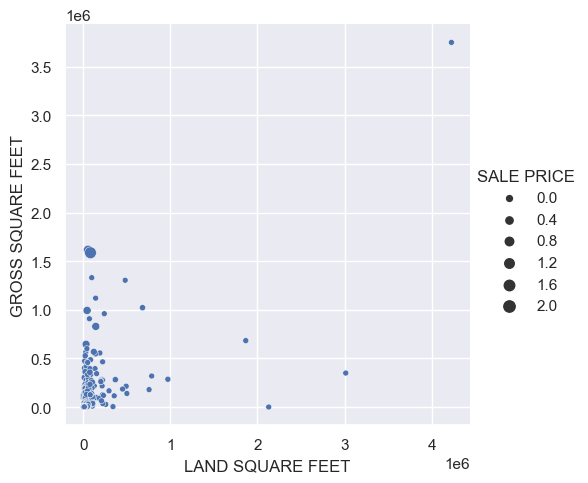

In [45]:
sns.relplot(data=df, x='LAND SQUARE FEET', y='GROSS SQUARE FEET', size='SALE PRICE')

#### YEAR BUILT
I have decided to bin years into decades to lower cardinality.  
I will also inpute missing values with top value per neighborhood.  
And take a look on the distribution of houses built in each decade in each BOUROUGH.

In [46]:
df['YEAR BUILT'].replace(0, np.nan, inplace=True)
df['YEAR BUILT'].replace(1111, np.nan, inplace=True)

In [47]:
# Looking on total missing values in YEAR BUILT
print(round(df['YEAR BUILT'].isna().sum() / df['YEAR BUILT'].shape[0] * 100,2), '% of values are missing.')

8.25 % of values are missing.


In [48]:
def get_most_often_value(groupByObject, column_name):
    return groupByObject[column_name].value_counts().index[0]

In [49]:
grouping  = df[['YEAR BUILT','NEIGHBORHOOD']][df['YEAR BUILT'].notna()].groupby('NEIGHBORHOOD')
mapping_for_missing = {}
for i in grouping:
    mapping_for_missing[i[0]] = get_most_often_value(i[1], 'YEAR BUILT')
print(list(mapping_for_missing.items())[:3]) # checking first 3 values

[('AIRPORT LA GUARDIA', 1950.0), ('ALPHABET CITY', 2014.0), ('ANNADALE', 1975.0)]


In [50]:
# impute missing values in YEAR BUILT with values from mapping_for_missing
df['YEAR BUILT'] = df['YEAR BUILT'].fillna(df['NEIGHBORHOOD'].map(mapping_for_missing))

In [51]:
# bin year built into 10 year intervals
df['YEAR BUILT binned'] = df['YEAR BUILT']
for i, decade in enumerate(range(1890, 2020, 10)):
    if i == 0:
        df['YEAR BUILT binned'] = df['YEAR BUILT binned'].apply(lambda x: x if x > decade else decade)
    df['YEAR BUILT binned'] = df['YEAR BUILT binned'].apply(lambda x: x if x < decade or x >=decade+10 else decade)
    if i == len(range(1890, 2020, 10)) - 1:
        df['YEAR BUILT binned'] = df['YEAR BUILT binned'].apply(lambda x: x if x < decade else decade)

In [52]:
df['YEAR BUILT binned'] = df['YEAR BUILT binned'].astype('int64')
df['YEAR BUILT binned'] = df['YEAR BUILT binned'].astype('category')

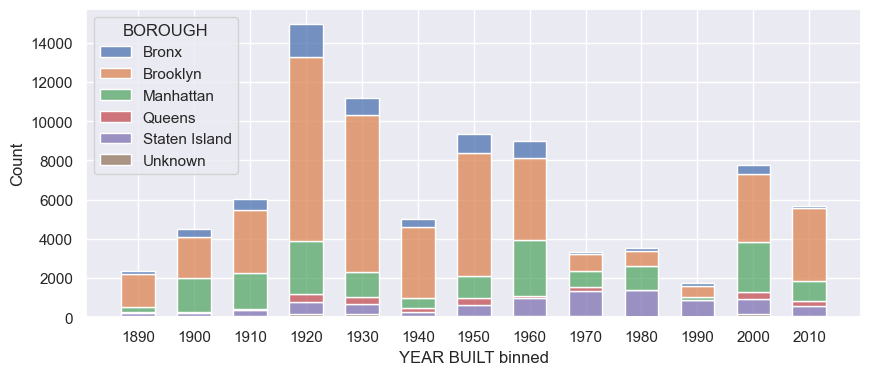

In [53]:
plt.figure(figsize=(10,4))
g = sns.histplot(x=df['YEAR BUILT binned'], hue=df['BOROUGH'], multiple='stack', shrink=6)
g.set_xticks(df['YEAR BUILT binned'].cat.categories) # <--- set the ticks first
g.set_xticklabels(df['YEAR BUILT binned'].cat.categories, ) # <--- set the labels second
plt.show()

In [54]:
df = df.drop(columns=['YEAR BUILT']).copy(deep=True)

### SALE DATE 
As we can see from the distribution of values, we have only 1 year of data. I don't think we can get any insights from this column. I will drop it.

In [55]:
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], format='%m/%d/%Y')

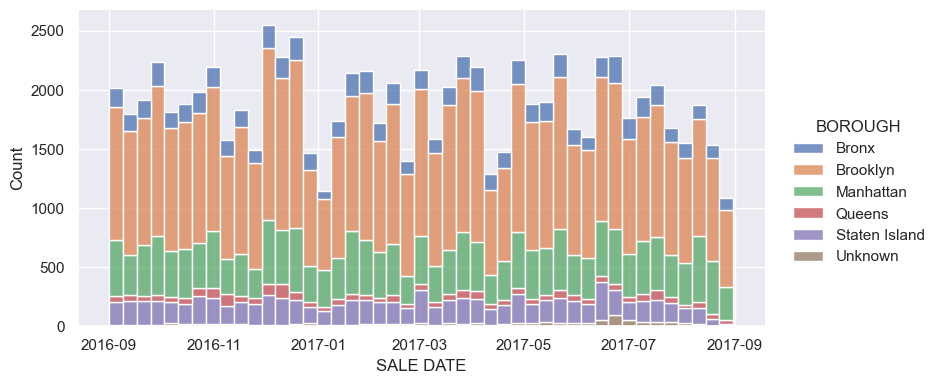

In [56]:
g2 = sns.displot(data=df, x='SALE DATE', hue='BOROUGH', multiple='stack', shrink=1, height=4, aspect=2)
plt.show()

In [57]:
df = df.drop(columns=['SALE DATE']).copy(deep=True)

### Final look on our features
Here I will drop rows if needed (I was preserving rows until now to be able to run statistics on data) and take a final look on features.

In [58]:
df = df.drop_duplicates().copy(deep=True)

In [59]:
# drop rows with BOROUGH == 'Unknown'
df = df[df['BOROUGH'] != 'Unknown']

#### SALE PRICE
* We have replaced missing values with NaN and converted to numeric this column earlier.  
* But after taking closer look I see many values of 0 and 10. Which means those values are missing or misspellings and do not represent actual sale price.  
* I will replace them with nan and see how many values are missing out of 84548.  
* After replacing 0 and 10 with nan I have 30.23% of missing values. I will drop rows with missing values. After drop we will still have suficient ammount of data (59213 rows).

In [60]:
df['SALE PRICE'] = df['SALE PRICE'].replace(0, np.nan)
df['SALE PRICE'] = df['SALE PRICE'].replace(10, np.nan)

In [61]:
print(round(df['SALE PRICE'].isna().sum() / df['SALE PRICE'].shape[0] * 100,2), '% of values are missing.')

28.77 % of values are missing.


In [62]:
df = df.dropna(subset=['SALE PRICE']).copy(deep=True)
df.shape

(57443, 15)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57443 entries, 0 to 84547
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   BOROUGH                    57443 non-null  category
 1   NEIGHBORHOOD               57443 non-null  category
 2   BUILDING CLASS CATEGORY    57443 non-null  category
 3   BLOCK                      57443 non-null  int64   
 4   LOT                        57443 non-null  int64   
 5   ZIP CODE                   57443 non-null  category
 6   RESIDENTIAL UNITS          57443 non-null  category
 7   COMMERCIAL UNITS           57443 non-null  category
 8   TOTAL UNITS                57443 non-null  category
 9   LAND SQUARE FEET           37100 non-null  float64 
 10  GROSS SQUARE FEET          28550 non-null  float64 
 11  TAX CLASS AT TIME OF SALE  57443 non-null  category
 12  SALE PRICE                 57443 non-null  float64 
 13  CHANGE IN BUILDING CLASS   5744

In [64]:
# now running the report again 
# profile2 = df.profile_report( title='NYC Rolling Sales Report-AFTER CLEANING', minimal=True)
# profile2.to_file(output_file="NYC Rolling Sales Report-AFTER CLEANING.html")
# df.profile_report( title='NYC Rolling Sales Report-AFTER CLEANING', minimal=True)

####  NEIGHBORHOOD, BLOCK, ZIP CODE, BOROUGH 
* Looking into data we can say that NEIGHBORHOOD, BLOCK, ZIP CODE, LOT, BOROUGH are basically represend the same thing logically.  
* Not to shoot in the sky with my above statement, I will check correlation between them using Phi_K. See Heatmap below.
* So, I will drop NEIGHBORHOOD, BLOCK, LOT, ZIP CODE.

In [65]:
df[['NEIGHBORHOOD','BLOCK', 'LOT', 'ZIP CODE', 'BOROUGH']].dtypes

NEIGHBORHOOD    category
BLOCK              int64
LOT                int64
ZIP CODE        category
BOROUGH         category
dtype: object

In [66]:
df_corr2 = pd.DataFrame()

codes, uniques = pd.factorize(df['NEIGHBORHOOD'])
df_corr2['NEIGHBORHOOD'] = codes
codes2, uniques2 = pd.factorize(df['BOROUGH'])
df_corr2['BOROUGH'] = codes2

df_corr2['ZIP CODE'] = df['ZIP CODE'].astype('int64')
df_corr2[['BLOCK', 'LOT']] = df[['BLOCK', 'LOT']]

interval columns not set, guessing: ['NEIGHBORHOOD', 'BOROUGH', 'ZIP CODE', 'BLOCK', 'LOT']


<AxesSubplot: >

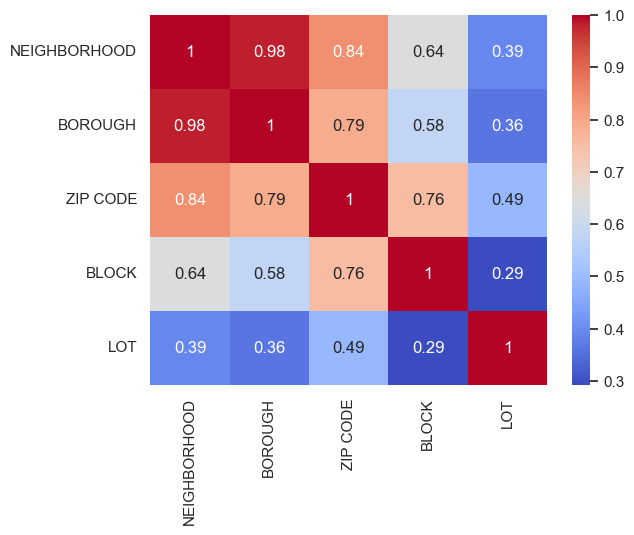

In [67]:
sns.heatmap(df_corr2.phik_matrix(), annot=True, cmap='coolwarm')

In [68]:
df = df.drop(columns=['NEIGHBORHOOD','BLOCK', 'LOT', 'ZIP CODE']).copy(deep=True)

#### BUILDING CLASS CATEGORY 
As we can see from report, column BUILDING CLASS CATEGORY have high cardinality.  
I will use a function to bin values into categories.

In [69]:
# Creating an aggregation function
def cumulatively_categorise(column,threshold=0.20,return_categories_list=True):
    threshold_value=int(threshold*len(column))
    categories_list=[]
    s=0
    counts=Counter(column)

    for i,j in counts.most_common():
        s+=dict(counts)[i]
        categories_list.append(i)
        if s>=threshold_value:
            break

    categories_list.append('Other')

    new_column=column.apply(lambda x: x if x in categories_list else 'Other')

    if(return_categories_list):
        return new_column,categories_list
    else:
        return new_column

#### BUILDING CLASS CATEGORY
* Also will reduce cardinality of BUILDING CLASS CATEGORY.

In [70]:
transformed_column2,new_category_list2=cumulatively_categorise(df['BUILDING CLASS CATEGORY'],threshold=0.8)
transformed_column2.describe()

count                                           57443
unique                                              6
top       01 ONE FAMILY DWELLINGS                    
freq                                            12707
Name: BUILDING CLASS CATEGORY, dtype: object

In [71]:
df['BUILDING CLASS CATEGORY binned'] = transformed_column2

In [72]:
df['BUILDING CLASS CATEGORY binned'] = df['BUILDING CLASS CATEGORY binned'].astype('category')

In [73]:
df = df.drop(columns=['BUILDING CLASS CATEGORY']).copy(deep=True)

#### LAND SQUARE FEET and GROSS SQUARE FEET
* Now we can drop rows with missing values for both columns.

In [74]:
df = df.dropna(subset=['LAND SQUARE FEET', 'GROSS SQUARE FEET'], how='any').copy(deep=True)
df.shape

(28546, 11)

In [75]:
# now running the report again 
# profile3 = df.profile_report( title='NYC Rolling Sales Report-AFTER CLEANING2', minimal=False)
# profile3.to_file(output_file="NYC Rolling Sales Report-AFTER CLEANING2.html")
# df.profile_report( title='NYC Rolling Sales Report-AFTER CLEANING2', minimal=True)

### Adding Commercial or residential column
* I have decided to add a column to indicate whether the property is commercial or residential.  
* As we can see on the report Commercial Units are about 90% have 0 value. 
* This way I can drop COMMERCIAL UNITS and RESIDENTIAL UNITS columns and keep IS COMMERCIAL and TOTAL UNITS columns without loosing much information.

In [76]:
df['IS COMMERCIAL'] = np.where(df['COMMERCIAL UNITS'] == '0', 0, 1)

In [77]:
df['IS COMMERCIAL'] = df['IS COMMERCIAL'].astype('category')

In [78]:
df['IS COMMERCIAL'].value_counts()


0    25908
1     2638
Name: IS COMMERCIAL, dtype: int64

In [79]:
df = df.drop(columns=['COMMERCIAL UNITS', 'RESIDENTIAL UNITS']).copy(deep=True)

#### LAND SQUARE FEET, GROSS SQUARE FEET, SALE PRICE
All are highly skewed. 
* I will remove sales price lower than 20k as it may be a mistake or some transfer, not a sale.  
* Correlation is high in 'LAND SQUARE FEET', 'GROSS SQUARE FEET' so I will keep only Gross Square Feet.  
* Then remove outliers over 3 standard deviations.  

In [80]:
# removing sales price lower than 20k as it may be a mistake or some transfer, not a sale.
df = df[df['SALE PRICE'] > 20000].copy(deep=True)
df.shape

(28147, 10)

In [81]:
df[['LAND SQUARE FEET', 'GROSS SQUARE FEET']].corr()

,LAND SQUARE FEET,GROSS SQUARE FEET
LAND SQUARE FEET,1.00,0.67
GROSS SQUARE FEET,0.67,1.00


In [82]:
df = df.drop(columns=['LAND SQUARE FEET']).copy(deep=True)

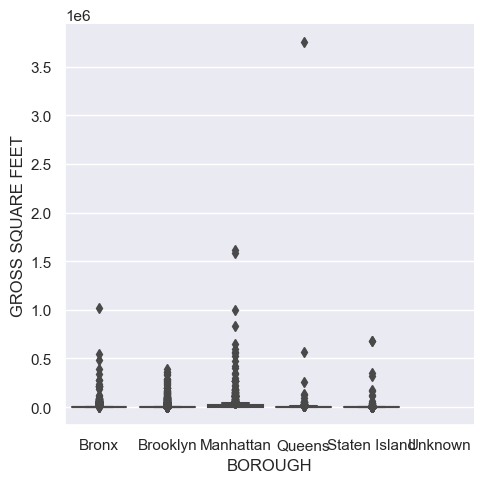

In [83]:
sns.catplot(
    data=df, x="BOROUGH", y="GROSS SQUARE FEET",  
    kind="box", dodge=False,
)
plt.show()

In [84]:
# calculate summary statistics
data_mean = df['GROSS SQUARE FEET'].mean()
data_std = df['GROSS SQUARE FEET'].std()
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in df['GROSS SQUARE FEET'] if x < lower or x > upper]
len(outliers)

134

In [85]:
# remove outliers
df = df[df['GROSS SQUARE FEET'] < upper].copy(deep=True)
df = df[df['GROSS SQUARE FEET'] > lower].copy(deep=True)
df.shape

(28013, 9)

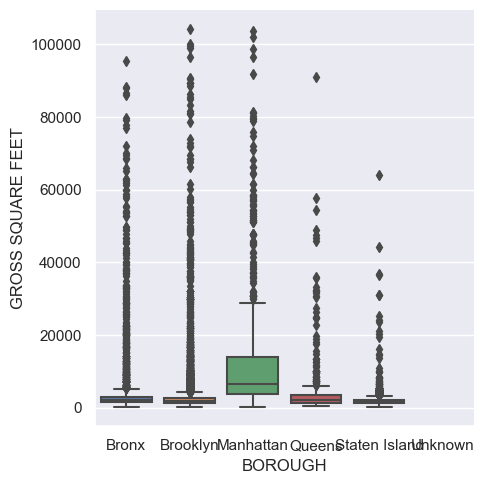

In [86]:
sns.catplot(
    data=df, x="BOROUGH", y="GROSS SQUARE FEET",  
    kind="box", dodge=False,
)
plt.show()

In [87]:
# now running the report again 
# profile4 = df.profile_report( title='NYC Rolling Sales Report-AFTER CLEANING3', minimal=False)
# profile4.to_file(output_file="NYC Rolling Sales Report-AFTER CLEANING3.html")
# df.profile_report( title='NYC Rolling Sales Report-AFTER CLEANING3', minimal=True)

In [88]:
df.columns

Index(['BOROUGH', 'TOTAL UNITS', 'GROSS SQUARE FEET',
       'TAX CLASS AT TIME OF SALE', 'SALE PRICE', 'CHANGE IN BUILDING CLASS',
       'YEAR BUILT binned', 'BUILDING CLASS CATEGORY binned', 'IS COMMERCIAL'],
      dtype='object')

In [89]:
print(df.dtypes)

BOROUGH                           category
TOTAL UNITS                       category
GROSS SQUARE FEET                  float64
TAX CLASS AT TIME OF SALE         category
SALE PRICE                         float64
CHANGE IN BUILDING CLASS          category
YEAR BUILT binned                 category
BUILDING CLASS CATEGORY binned    category
IS COMMERCIAL                     category
dtype: object


#### Few insight graphs from data before modeling

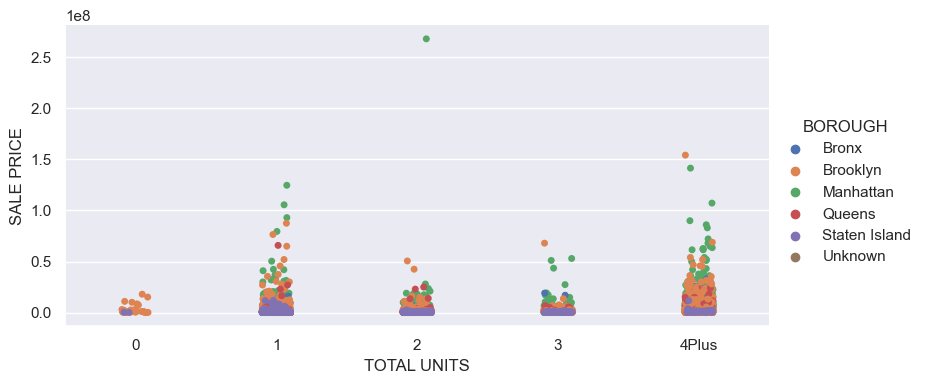

In [90]:
sns.catplot(data=df, x='TOTAL UNITS', y='SALE PRICE', hue='BOROUGH',height=4, aspect=2)

* Here we can see that One bedroom properties in NYC very popular and Manhattan and somewhat in Brooklyn prices are higher for 1 bedroom appartments.   
* Also properties with 4+ bedrooms are more expensice over all , especially in Manhattan and Brooklyn.  
* Staten Islan tend to be on the lower end of the price spectrum for all types of properties.  


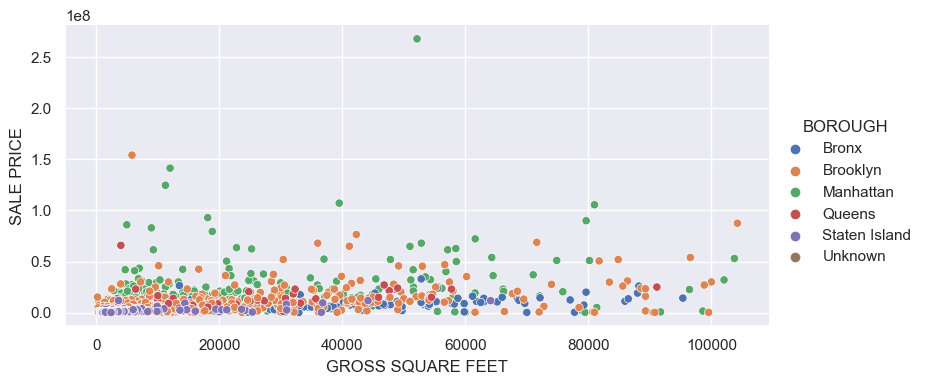

In [91]:
sns.relplot(data=df, x='GROSS SQUARE FEET', y='SALE PRICE', hue='BOROUGH',height=4, aspect=2)

* As we can see here, sales Price is not much affected by the Gross Square feet. But more effected by Borough.

<AxesSubplot: xlabel='GROSS SQUARE FEET', ylabel='SALE PRICE'>

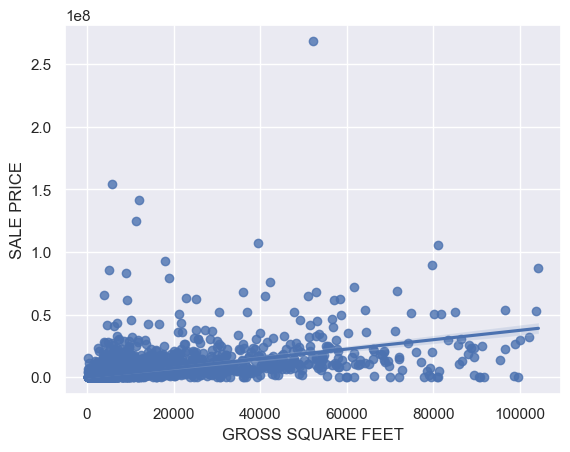

In [92]:
sns.regplot(data=df, x='GROSS SQUARE FEET', y='SALE PRICE')

* Sales Price is not much affected by the Gross Square feet. Only somewhat correlated.

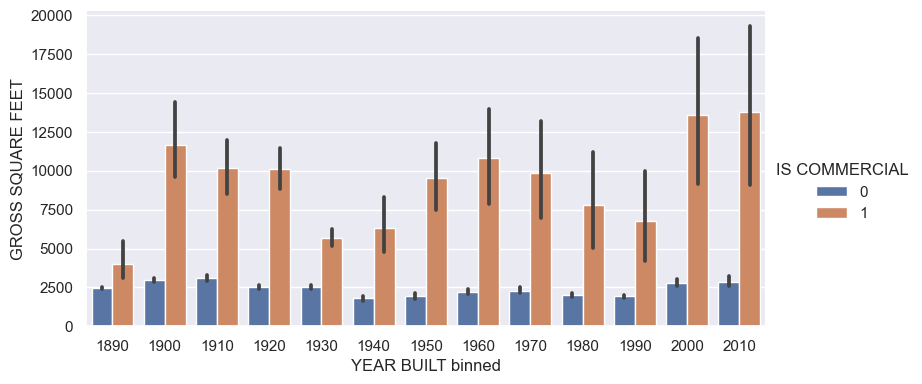

In [93]:
sns.catplot(data=df, x='YEAR BUILT binned', y='GROSS SQUARE FEET', hue='IS COMMERCIAL', kind='bar',height=4, aspect=2)

* As expected Commercial properties having larger overall square feet.
* Commercial properties built in last 2 decades tend to be larger.

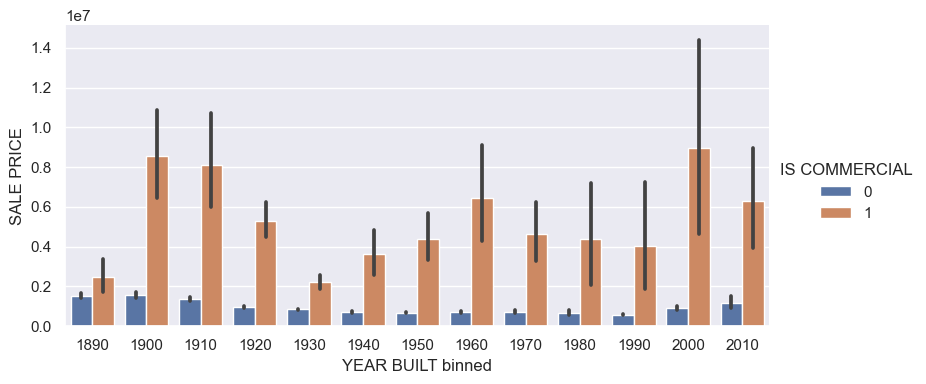

In [94]:
sns.catplot(data=df, x='YEAR BUILT binned', y='SALE PRICE', hue='IS COMMERCIAL', kind='bar',height=4, aspect=2)

<AxesSubplot: xlabel='YEAR BUILT binned', ylabel='count'>

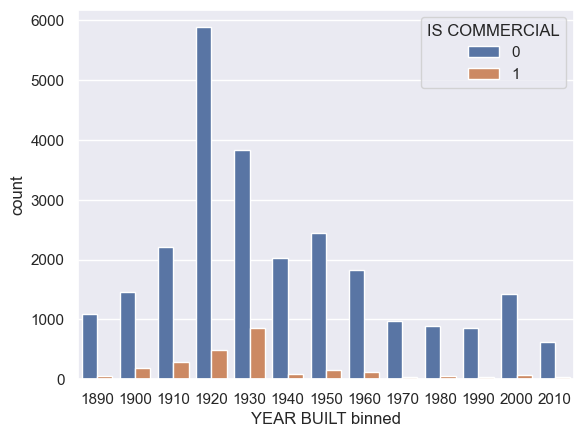

In [95]:
sns.countplot(data=df, x='YEAR BUILT binned', hue='IS COMMERCIAL')

* By count the most buildings, which were sold in a given 1 year period were built in 1920s and 1930s. 

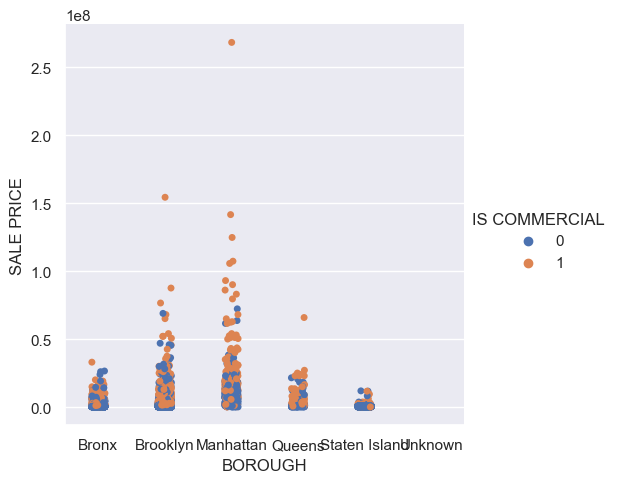

In [96]:
sns.catplot(data=df, y='SALE PRICE', x='BOROUGH', hue='IS COMMERCIAL')

* Mahattan and Brooklyn have the most expensive commercial properties. Staten Island has the least expensive commercial properties and tend to be much cheaper than all other boroughs.

#### Feature Encoding
* I will use One Hot Encoding for:  
BOROUGH, TAX CLASS AT TIME OF SALE,CHANGE IN BUILDING CLASS, BUILDING CLASS CATEGORY binned, IS COMMERCIAL - as those are Nominal Categorical variables.  
* And Label Encoding for:  TOTAL UNITS, YEAR BUILT binned - as those are Ordinal Categorical variables.  


In [97]:
nom_cols = ['BOROUGH', 'TAX CLASS AT TIME OF SALE','CHANGE IN BUILDING CLASS', 'BUILDING CLASS CATEGORY binned', 'IS COMMERCIAL']
ord_cols = ['TOTAL UNITS', 'YEAR BUILT binned']
num_cols = ['GROSS SQUARE FEET', 'SALE PRICE']

In [98]:
# pandas one hot encoding on nominal columns
df_encoded = pd.get_dummies(df, columns=nom_cols, drop_first=False)
df_encoded.shape

(28013, 24)

In [99]:
# ordinal encoding on ordinal columns
ordinal_encoder = ce.OrdinalEncoder(cols=ord_cols, return_df=True, 
                                    mapping=[
{'col':'TOTAL UNITS',
'mapping' : {'0':0,'1':1,'2':2,'3':3,'4Plus':4}},
{'col':'YEAR BUILT binned',
'mapping' : {1880:0, 1890:1, 1900:2, 1910:3, 1920:4, 1930:5, 1940:6, 1950:7, 1960:8, 1970:9, 1980:10, 1990:11, 2000:12, 2010:13, 2020:14}}
])
df_encoded[ord_cols] = ordinal_encoder.fit_transform(df[ord_cols])

In [100]:
df_encoded.head(2)

,TOTAL UNITS,GROSS SQUARE FEET,SALE PRICE,YEAR BUILT binned,BOROUGH_Bronx,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten Island,BOROUGH_Unknown,TAX CLASS AT TIME OF SALE_1,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_3,TAX CLASS AT TIME OF SALE_4,CHANGE IN BUILDING CLASS_0,CHANGE IN BUILDING CLASS_1,BUILDING CLASS CATEGORY binned_01 ONE FAMILY DWELLINGS,BUILDING CLASS CATEGORY binned_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY binned_09 COOPS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY binned_10 COOPS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY binned_13 CONDOS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY binned_Other,IS COMMERCIAL_0,IS COMMERCIAL_1
0,4,6440.00,6625000.00,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0
3,4,6794.00,3936272.00,3,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0


#### Feature Scaling. Model Selection and Hyperparameter Tuning
I will use Multiple Linear Regression as a baseline model.  
And use to compare:  
* Ridge Regression - if I decide to use specifically selected features ( which I have now)  
* Robust Regression - to see if it will help with data having many points in 3 std range for some features,  
* Decision tree,  
* Random Forest Regressor,  
* Support Vector Regressor,  
* XGBoost Regressor,  
* Neural Network ?    

##### Evaluation
Mean Squared Error,
Mean Absolute Error,
R2 Score.

*** Cross Validation ***


In [101]:
X = df_encoded.drop(columns=['SALE PRICE'])
y = df_encoded['SALE PRICE']

#### Linear Regression

In [102]:
# Build Linear Regression Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)

# Build Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
print('R2: ', r2_score(y_test, y_pred)) # Coefficient of Determination. % of variance of the dependent variable explained by the model.
print('MAE: $', round(mean_absolute_error(y_test, y_pred),2))
print('MSE: $**2', (mean_squared_error(y_test, y_pred))) 
print('RMSE: $', round(np.sqrt(mean_squared_error(y_test, y_pred)),2)) #  Standard Deviation of the residuals

R2:  0.49844209530309636
MAE: $ 664662.26
MSE: $**2 7230750026930.701
RMSE: $ 2689005.4


In [103]:
print('Sales Price Mean: $', round(np.mean(df['SALE PRICE']),2))
print('Sales Price Median: $',round(np.median(df['SALE PRICE']),2))

Sales Price Mean: $ 1279837.91
Sales Price Median: $ 635000.0


* After running Linear Regression we have R2 score of 0.49, which means that 36% of variance in the target variable is explained by the model (our features). We can also say that our model predicts 49% better than simply taking the mean of the target variable.  
* However knowing that we have few very expensive properties, which are skewing the data, we can use median (635000.0) to compare our model performance to Mean absolute error (MAE 664662.26). And meadian does better job in this case.  
* We can use RMSE to compate our Linear Regression model with other models. As it has the same units as our target variable.

#### Lasso Regression
* We will use improved version of Lasso Regression, which will select Alpha value for us.

In [104]:
pd.set_option('max_colwidth', 80)

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lasso = LassoCV().fit(X_train, y_train)
y_pred = lasso.predict(X_test)

print('Lasso R2 Score: ', r2_score(y_test, y_pred)) # R2 - Coefficient of Determination.
print('MAE: $', round(mean_absolute_error(y_test, y_pred),2))
print('RMSE: $',round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
print('MSE: $**2', (mean_squared_error(y_test, y_pred))) 
print('Lasso Coefficients: ' )
pd.DataFrame(index=X.columns, data=lasso.coef_, columns=['Coefficients'])

Lasso R2 Score:  0.4980302625263384
MAE: $ 660284.27
RMSE: $ 2690109.15
MSE: $**2 7236687247406.636
Lasso Coefficients: 


,Coefficients
TOTAL UNITS,-0.00
GROSS SQUARE FEET,1955797.90
YEAR BUILT binned,534.83
BOROUGH_Bronx,-216232.33
BOROUGH_Brooklyn,0.00
BOROUGH_Manhattan,1099286.01
BOROUGH_Queens,32984.40
BOROUGH_Staten Island,-117950.24
BOROUGH_Unknown,0.00
TAX CLASS AT TIME OF SALE_1,0.00


* we can see from above that Lasso Regression didn't improve our model performance. R2 is basically the same and RMSE is even higher.
* we can briefly look at coefficients of our model. We can see that some of them are 0, which means they were ommited by Lasso model.
* Ridge was giving preaty much the same results as Lasso, so I will not go into details.

#### Decision Tree Regressor

In [106]:
#decision tree regressor with grid search
pipe = make_pipeline(DecisionTreeRegressor())
param_grid = {'decisiontreeregressor__max_depth': [3, 5, 7, 9, 11],
                'decisiontreeregressor__min_samples_split': [1, 2, 3, 4],
                'decisiontreeregressor__min_samples_leaf': [1, 2, 3, 4]}
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='r2')
# grid.fit(X, y)
# grid.best_params_
'''
{'decisiontreeregressor__max_depth': 7,
 'decisiontreeregressor__min_samples_leaf': 1,
 'decisiontreeregressor__min_samples_split': 4}
 '''

"\n{'decisiontreeregressor__max_depth': 7,\n 'decisiontreeregressor__min_samples_leaf': 1,\n 'decisiontreeregressor__min_samples_split': 4}\n "

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)

dt = DecisionTreeRegressor(max_depth=5, min_samples_split=1, min_samples_leaf=1)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print('Decision Tree R2 Score: ', r2_score(y_test, y_pred)) # R2 - Coefficient of Determination.
print('MAE: $', round(mean_absolute_error(y_test, y_pred),2))
print('RMSE: $',round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
print('MSE: $**2', (mean_squared_error(y_test, y_pred)))

Decision Tree R2 Score:  0.369179234503065
MAE: $ 644646.56
RMSE: $ 3015672.15
MSE: $**2 9094278495843.566


* Decision Tree Regressor didn't improve our model performance. R2 and RMSE are lower than Linear Regression.

#### XGBoost Regressor

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)

pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', XGBRegressor())])
param_grid = {'regressor__n_estimators': [100, 200, 300],
                'regressor__max_depth': [3, 5, 7],
                'regressor__learning_rate': [0.01, 0.05, 0.1]}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
pipeline.fit(X_train, y_train)
# grid.fit(X_train, y_train)
# grid.best_params_
"""
{'regressor__learning_rate': 0.05,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 200}
 """

"\n{'regressor__learning_rate': 0.05,\n 'regressor__max_depth': 3,\n 'regressor__n_estimators': 200}\n "

In [112]:
xgb = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.05)
xgb.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('XGBoost Test R2 Score: ', r2_score(y_test, y_pred))
print('MAE: $', round(mean_absolute_error(y_test, y_pred),2))
print('MSE: $**2', (mean_squared_error(y_test, y_pred)))
print('RMSE: $',round(np.sqrt(mean_squared_error(y_test, y_pred)),2))

XGBoost Test R2 Score:  0.48698737626225885
MAE: $ 615341.78
MSE: $**2 7395887908793.159
RMSE: $ 2719538.18


#### Support Vector Regressor

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svr = SVR(C=10, gamma=0.01, kernel='rbf')
svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

print('SVR R2 Score: ', r2_score(y_test, y_pred))
print('MAE: $', round(mean_absolute_error(y_test, y_pred),2))
print('RMSE: $',round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
print('MSE: $**2', (mean_squared_error(y_test, y_pred)))

SVR R2 Score:  -0.02926130368879787
MAE: $ 871842.9
RMSE: $ 3852068.1
MSE: $**2 14838428683252.389


### Conclusion
* From the graphs above we can see that the most correlated features are:  
[Borough, Is Commercial, Total Units]
* From 1 year sales data I think I can safely assume that most of the NY buildings were buit during early 20th century.  
* Commercial properties of much more expensive than residential properties and tend to have higher Unit count and larger square feet.
* Manhattan and Brooklyn have the most expensive commercial properties. That's were the most business at. Staten Island has the least expensive commercial properties and tend to be much cheaper than all other boroughs. It looks more like a family oriented place.

* I have taken a Filtering feature selection approach, as time was limited to try Forward or Backward feature selection.

* After running different models above, I can say that Linear Regression is the best model for this data. As it is easy to interpret and has the best performance.
* After running Linear Regression we have R2 score of 0.49, which means that 36% of variance in the target variable is explained by the model (our features). We can also say that our model predicts 49% better than simply taking the mean of the target variable.  
* However knowing that we have few very expensive properties, which are skewing the data, we can use median (635000.0) to compare our model performance to Mean absolute error (MAE 664662.26). And meadian does better job in this case.  

* I Would not reccoment using this system at the present time. As it is not very accurate. And simple median from adjusted (we cut off sales lower than $20k) SALES PRICE can do better. 

##### Suggested improvements
* Rerun Lasso, Decision Tree for all features, not just selected ones. And compare results to what I have now. Seems like the model could be overfitted giving R2 with high variance.
* Adjust Dependent variable SALES PRICE for outliers.
* Try to save more data from the original dataset. As I have lost a lot of data during cleaning. Perhaps try different imutation methods for rows with missing GROSS SQUARE FEET and LAND SQUARE FEET.

#### 